In [12]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Masking, Input, Multiply, Add, Activation, concatenate
from tensorflow.keras import Model

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from copy import deepcopy, copy

In [2]:
def min_max_scaler(df_train,df_test,columns=None,MAX=1,MIN=0):
    
    if columns is None:
        columns = df_train.columns

    for col in columns:
        maximum = df_train.loc[:,col].max()
        minimum = df_train.loc[:,col].min()
        df_train.loc[:,col]=(MAX-MIN)*(df_train.loc[:,col]-maximum)/(maximum-minimum) + MAX
        df_test.loc[:,col]=(MAX-MIN)*(df_test.loc[:,col]-maximum)/(maximum-minimum) + MAX
        
    return df_train, df_test

def make_data(df_input,df_target,n_previous_days):   
    dates=df_input.index.date
    dates=np.unique(dates)
    
    inputs=[]
    outputs=[]
    
    for i in range(dates.shape[0]-n_previous_days):
        
        date0=dates[i].strftime('%Y-%m-%d')
        date1=dates[i+n_previous_days].strftime('%Y-%m-%d')
        
        date1_open_GHR = date1+ ' 11:00:00'
        date1_close_GHR = date1+ ' 14:00:00'
        
        max_ghr = df_target.loc[date1_open_GHR:date1_close_GHR].max()
        
        if math.isnan(max_ghr):
            pass
        
        else:
            
            outputs.append(max_ghr)
            
            date1_till_9 =  date1 +' 09:00:00'
            in_seq = df_input.loc[date0:date1_till_9].to_numpy()

            inputs.append(in_seq)
        
    return np.stack(inputs), np.stack(outputs).reshape(-1,1)

In [3]:
df = pd.read_csv('3052-Site_Environment-DG_Weather_Station_04-2016_05-2022.csv')
df.Timestamp = df.Timestamp.astype(np.datetime64) #set 'Timestamp' to np.datetime type
df = df.set_index('Timestamp') # set 'Timestamp' column as index
df = df.resample('H').first() #Fill all the missing timesteps with Nan 
df = df.drop(columns=['Hail_Accumulation','Temperature_Probe_1','Temperature_Probe_2','Max_Wind_Speed','Pyranometer_1'])

df=df.loc[(df.index > '2016-05-17 23:00:00')]

unique_dates = np.unique(df.index.date)
split_value=0.8

split_date = unique_dates[int(split_value*unique_dates.shape[0])]
split_date = np.datetime64(split_date)

df_train = df.loc[:(split_date-1).item().strftime('%Y-%m-%d')]
df_test = df.loc[(split_date).item().strftime('%Y-%m-%d'):]

df_train_target=df_train['Global_Horizontal_Radiation'].copy(deep=True)
df_test_target=df_test['Global_Horizontal_Radiation'].copy(deep=True)

In [4]:
df_train_input , df_test_input = min_max_scaler(df_train, df_test)
MASK_VALUE=7.
df_train_input = df_train_input.fillna(MASK_VALUE)
df_test_input = df_test_input.fillna(MASK_VALUE)

C:\Users\mattia_pavese\anaconda3\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [5]:
inputs_train,outputs_train=make_data(df_train_input,df_train_target,2)
inputs_test,outputs_test=make_data(df_test_input,df_test_target,2)

## Tf model with stock layers 

In [181]:

timesteps=inputs_train.shape[1]
features=inputs_train.shape[2]

lstm_inputs = Input(shape=(timesteps,features))
mask=Masking(mask_value=MASK_VALUE,input_shape=(timesteps, features)) #recall that mask value has been decided to be 7.

lstm = tf.keras.layers.LSTM(32,return_state=True)
dense = Dense(8,activation='relu')
dense_out = Dense(1,activation='linear')

masked_inputs=mask(lstm_inputs)
outputs,_,_ = lstm(masked_inputs)
outputs=dense(outputs)
outputs=dense_out(outputs)

model=Model(inputs=lstm_inputs,outputs=outputs)

 
model.compile(optimizer='adam',loss='mse')

In [182]:
%%time
model.fit(inputs_train,outputs_train,epochs=100,batch_size=16)

Epoch 1/100
106/106 [==============================] - 6s 25ms/step - loss: 802297.9375
Epoch 2/100
106/106 [==============================] - 3s 25ms/step - loss: 788592.1875
Epoch 3/100
106/106 [==============================] - 3s 24ms/step - loss: 776077.5000
Epoch 4/100
106/106 [==============================] - 3s 26ms/step - loss: 761683.2500
Epoch 5/100
106/106 [==============================] - 3s 26ms/step - loss: 745137.0000
Epoch 6/100
106/106 [==============================] - 3s 24ms/step - loss: 726461.6875
Epoch 7/100
106/106 [==============================] - 3s 24ms/step - loss: 705797.8750
Epoch 8/100
106/106 [==============================] - 3s 26ms/step - loss: 683261.0000
Epoch 9/100
106/106 [==============================] - 3s 25ms/step - loss: 659060.3125
Epoch 10/100
106/106 [==============================] - 3s 24ms/step - loss: 633423.8750
Epoch 11/100
106/106 [==============================] - 3s 25ms/step - loss: 606556.7500
Epoch 12/100
106/106 [========

mae: 163.62642
mse: 42010.055
mape: 18.607178


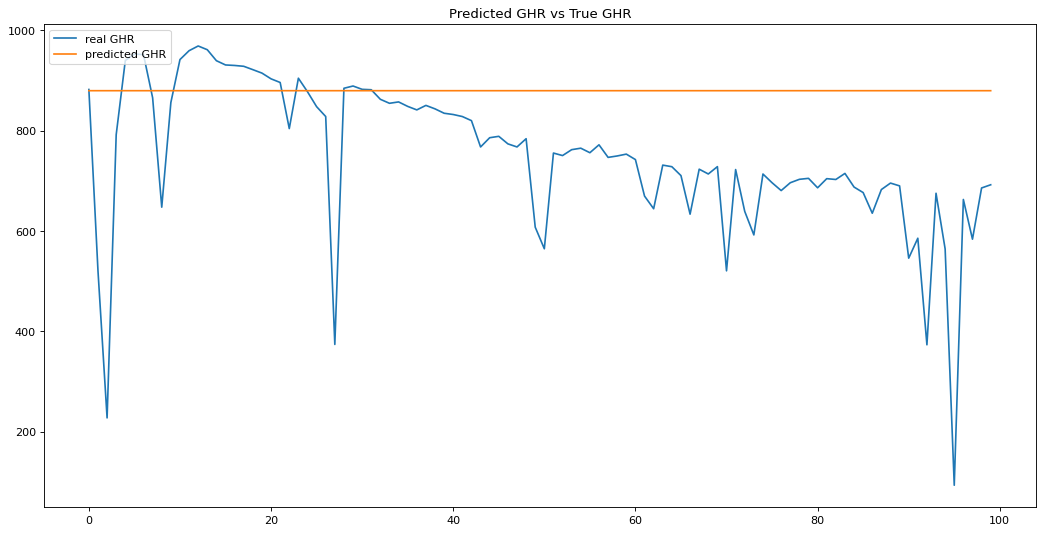

In [183]:
predictions=model.predict(inputs_test)

mse=tf.keras.metrics.MeanSquaredError()
mse.update_state(predictions.reshape(-1,), outputs_test.reshape(-1,))

mae= tf.keras.metrics.MeanAbsoluteError()
mae.update_state(predictions.reshape(-1,), outputs_test.reshape(-1,))

mape = tf.keras.metrics.MeanAbsolutePercentageError()
mape.update_state(predictions.reshape(-1,), outputs_test.reshape(-1,))


print('mae: '  +str(mae.result().numpy())) 
print('mse: '  +str(mse.result().numpy()))
print('mape: '  +str(mape.result().numpy())) 


figure(figsize=(16, 8), dpi=80)
plt.title('Predicted GHR vs True GHR')
plt.plot(outputs_test[:100], label='real GHR')
plt.plot(predictions[:100], label='predicted GHR')
plt.legend(loc="upper left")

plt.show()

## Tf model with custom LSTM layer

In [191]:
class __LSTM__(tf.keras.layers.Layer):
    
    def __init__(self, hidden_dim, return_sequence=False, states_initializer=None, mask_value=None, name='LSTM'):
        
        '''
        
        Args: 
        
        *hidden_dim: defines the output dimension for gates. Each gate outputs a tensor 
        with shape (batch_size, hidden_dim); 
        if return_sequence is True, the output sequence shape is (batch_size, length_sequence, hidden_dim), with 
        length_sequence and batch_size defined by the input tensor.
        
        *return_sequence=False: if True, returns are state_h, state_c, output_sequence; 
        otherwise, returns are state_h, state_c
        
        *state_initializer=None: defines initializer for state_h and state_c. If None, default RandomNormal is used.
        
        Returns: 
        
        if return_sequence==False:
            state_h, state_c, both with shape (batch_size, hidden_dim)
        if return_sequence==True:
            state_h, state_c, output_sequence, where output_sequence has shape (batch_size, length_sequence, hidden_dim)
        
        Both length_sequence and batch_size are defined based on input tensor (inputs in the "call" method)
        
        '''
        super(__LSTM__, self).__init__(name=name)
        
        self.hidden_dim = hidden_dim
        self.return_sequence=return_sequence
        self.mask_value = mask_value
        
        self.forget = Dense(self.hidden_dim, activation="sigmoid") #forget gate init
        self.input_= Dense(self.hidden_dim, activation="sigmoid") #input gate init
        self.candidate = Dense(self.hidden_dim, activation="tanh") #candidate gate init
        self.output_ = Dense(self.hidden_dim, activation="sigmoid") #output gate init
        
        #set the initializer for state h and c
        if (states_initializer is None):
            self.states_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        else:
            self.states_initializer=states_initializer
  
    
    def call(self, inputs):
        
        #random initialization of state h and state c 
        batch_size=tf.shape(inputs)[0]
        self.state_h = self.states_initializer(shape=(batch_size,self.hidden_dim)) 
        self.state_c = self.states_initializer(shape=(batch_size,self.hidden_dim))
        
        
        output_sequence = []
        
        for t in range(inputs.shape[1]):
            
            x_t = inputs[:,t,:]
            
            if self.mask_value is not None:
                state_h_copy, state_c_copy = tf.identity(self.state_h), tf.identity(self.state_c)
                mask = (x_t != 0.)
                mask = tf.reduce_any(mask, axis=1)
                mask = tf.transpose(tf.stack([mask]*self.hidden_dim),perm=[1,0])
            
            concat_inputs = concatenate([self.state_h,x_t],axis=1)
            
            #forward computations for gates
            forget = self.forget(concat_inputs)
            input_ = self.input_(concat_inputs)
            candidate = self.candidate(concat_inputs)
            output = self.output_(concat_inputs)
            
            #execute pointwise operatios between gates
            self.state_c = Multiply()([forget,self.state_c])
            candidate_accepted = Multiply()([input_,candidate])
            self.state_c = Add()([self.state_c,candidate_accepted])
            state_c_passed_in_tanh = Activation('tanh')(self.state_c)
            self.state_h = Multiply()([state_c_passed_in_tanh,output])
            
            if self.mask_value is not None:
                self.state_h = tf.where(mask,self.state_h,state_h_copy)
                self.state_c = tf.where(mask,self.state_c,state_c_copy)
            
            #append state h to output sequence
            output_sequence.append(self.state_h)
        
        if self.return_sequence:
            output_sequence=tf.stack(output_sequence,axis=1)
            return (self.state_h, self.state_c, output_sequence)
        else:
            return (self.state_h, self.state_c)
        

In [192]:
class __Model__(tf.keras.Model):

    def __init__(self, hidden_dim, mask_value):
        
        super(__Model__, self).__init__()
        
        self.lstm = __LSTM__(hidden_dim,mask_value=mask_value, return_sequence=False)
        
        self.dense = Dense(8,activation='relu')
        self.dense_out = Dense(1,activation='linear')

    def call(self, inputs):
        
        h, c = self.lstm(inputs)
        
        out=self.dense(h)
        out=self.dense_out(out)
        
        return out

In [193]:
model2=__Model__(32, MASK_VALUE)
model2.compile(optimizer='adam',loss='mse')

In [194]:
%%time
model2.fit(inputs_train,outputs_train,epochs=100,batch_size=16)

Epoch 1/100
106/106 [==============================] - 15s 11ms/step - loss: 804665.4375
Epoch 2/100
106/106 [==============================] - 1s 12ms/step - loss: 783466.5000
Epoch 3/100
106/106 [==============================] - 1s 12ms/step - loss: 750398.6250
Epoch 4/100
106/106 [==============================] - 1s 12ms/step - loss: 707854.9375
Epoch 5/100
106/106 [==============================] - 1s 12ms/step - loss: 657054.5625 
Epoch 6/100
106/106 [==============================] - 1s 12ms/step - loss: 599783.5000
Epoch 7/100
106/106 [==============================] - 1s 12ms/step - loss: 538223.4375
Epoch 8/100
106/106 [==============================] - 1s 12ms/step - loss: 474544.5312 0s -
Epoch 9/100
106/106 [==============================] - 1s 12ms/step - loss: 410966.1875
Epoch 10/100
106/106 [==============================] - 1s 12ms/step - loss: 349442.8750
Epoch 11/100
106/106 [==============================] - 1s 12ms/step - loss: 291826.5625
Epoch 12/100
106/106 [=

mae: 67.85439
mse: 11937.904
mape: 8.719186


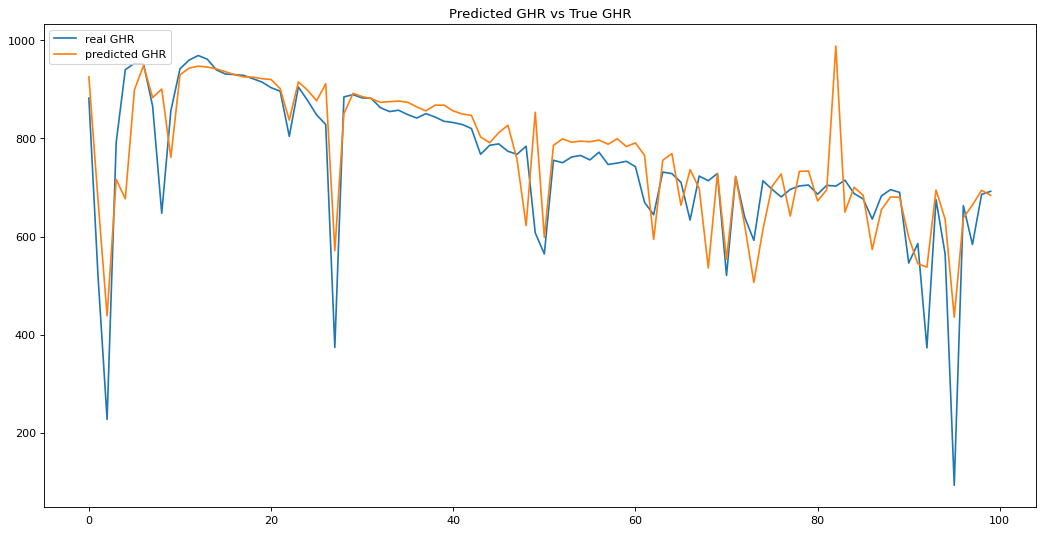

In [195]:
predictions=model2.predict(inputs_test)

mse=tf.keras.metrics.MeanSquaredError()
mse.update_state(predictions.reshape(-1,), outputs_test.reshape(-1,))

mae= tf.keras.metrics.MeanAbsoluteError()
mae.update_state(predictions.reshape(-1,), outputs_test.reshape(-1,))

mape = tf.keras.metrics.MeanAbsolutePercentageError()
mape.update_state(predictions.reshape(-1,), outputs_test.reshape(-1,))


print('mae: '  +str(mae.result().numpy())) 
print('mse: '  +str(mse.result().numpy()))
print('mape: '  +str(mape.result().numpy())) 


figure(figsize=(16, 8), dpi=80)
plt.title('Predicted GHR vs True GHR')
plt.plot(outputs_test[:100], label='real GHR')
plt.plot(predictions[:100], label='predicted GHR')
plt.legend(loc="upper left")

plt.show()

## Tf model with custom QLSTM layer

In [197]:
import pennylane as qml 
from pennylane import numpy as np

In [202]:
class __QLSTM__(tf.keras.layers.Layer):
    
    def __init__(self, hidden_dim, n_layers_vqc=1, return_sequence=False, mask_value=None, 
                 states_initializer=None, name='QLSTM'):
        
        '''
        
        Args: 
        
        *hidden_dim: defines the output dimension for gates and coincides with the NUMBER OF QUBITS in each vqc. 
        Each gate outputs a tensor with shape (batch_size, hidden_dim); 
        if return_sequence is True, the output sequence shape is (batch_size, length_sequence, hidden_dim), with 
        length_sequence and batch_size defined by the input tensor.
        
        *n_layers_vqc: number of layers of the variational quantum circuit inside each gate.
        
        *return_sequence=False: if True, returns are state_h, state_c, output_sequence; 
        otherwise, returns are state_h, state_c
        
        *state_initializer=None: defines initializer for state_h and state_c. If None, default RandomNormal is used.
        
        Returns: 
        
        if return_sequence==False:
            state_h, state_c, both with shape (batch_size, hidden_dim)
        if return_sequence==True:
            state_h, state_c, output_sequence, where output_sequence has shape (batch_size, length_sequence, hidden_dim)
        
        Both length_sequence and batch_size are defined based on input tensor (inputs in the "call" method)
        
        '''
        super(__QLSTM__, self).__init__(name=name)
        
        self.hidden_dim = hidden_dim
        self.n_layers_vqc=n_layers_vqc
        self.return_sequence=return_sequence
        self.mask_value=mask_value
        
        self.n_qubits=hidden_dim
        self.weight_shapes = {"weights": (n_layers_vqc, self.n_qubits)}
        
        
        #forget gate init
        
        self.wrapper_forget = Dense(self.n_qubits)
        
        self.dev_forget = qml.device("default.qubit",wires=self.n_qubits)
        @qml.qnode(self.dev_forget)
        def qnode_forget(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(self.n_qubits))
            qml.BasicEntanglerLayers(weights, wires=range(self.n_qubits))
            return [qml.expval(qml.PauliZ(wires=i)) for i in range(self.n_qubits)]
        self.quant_forget = qml.qnn.KerasLayer(qnode_forget, self.weight_shapes, output_dim=self.n_qubits)
        
        #_______________________________________________________________________________________________
        
        #input gate init
        
        self.wrapper_input = Dense(self.n_qubits)
        
        self.dev_input = qml.device("default.qubit",wires=self.n_qubits)
        @qml.qnode(self.dev_input)
        def qnode_input(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(self.n_qubits))
            qml.BasicEntanglerLayers(weights, wires=range(self.n_qubits))
            return [qml.expval(qml.PauliZ(wires=i)) for i in range(self.n_qubits)]
        self.quant_input = qml.qnn.KerasLayer(qnode_input, self.weight_shapes, output_dim=self.n_qubits)
        
        #_______________________________________________________________________________________________
        
        #candidate gate init
        
        self.wrapper_candidate = Dense(self.n_qubits)
        
        self.dev_candidate = qml.device("default.qubit",wires=self.n_qubits)
        @qml.qnode(self.dev_candidate)
        def qnode_candidate(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(self.n_qubits))
            qml.BasicEntanglerLayers(weights, wires=range(self.n_qubits))
            return [qml.expval(qml.PauliZ(wires=i)) for i in range(self.n_qubits)]
        self.quant_candidate = qml.qnn.KerasLayer(qnode_candidate, self.weight_shapes, output_dim=self.n_qubits)
        
        #_______________________________________________________________________________________________
        
        #output gate init
        
        self.wrapper_output = Dense(self.n_qubits)
        
        self.dev_output = qml.device("default.qubit",wires=self.n_qubits)
        @qml.qnode(self.dev_output)
        def qnode_output(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(self.n_qubits))
            qml.BasicEntanglerLayers(weights, wires=range(self.n_qubits))
            return [qml.expval(qml.PauliZ(wires=i)) for i in range(self.n_qubits)]
        self.quant_output = qml.qnn.KerasLayer(qnode_output, self.weight_shapes, output_dim=self.n_qubits)
        
        #_______________________________________________________________________________________________
        
        #set the initializer for state h and c
        
        if states_initializer is None:
            self.states_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        else:
            self.states_initializer=states_initializer
  
    
    def call(self, inputs):
        
        #random initialization of state h and state c 
        batch_size=tf.shape(inputs)[0]
        self.state_h = self.states_initializer(shape=(batch_size,self.hidden_dim)) 
        self.state_c = self.states_initializer(shape=(batch_size,self.hidden_dim))
        
        
        output_sequence =[]
        
        for t in range(inputs.shape[1]):
            
            x_t = inputs[:,t,:]
            
            if self.mask_value is not None:
                state_h_copy, state_c_copy = tf.identity(self.state_h), tf.identity(self.state_c)
                mask = (x_t != 0.)
                mask = tf.reduce_any(mask, axis=1)
                mask = tf.transpose(tf.stack([mask]*self.hidden_dim),perm=[1,0])
            
            
            concat_inputs = concatenate([self.state_h,x_t],axis=1)
            
            #forwad computations for gates
            forget = self.wrapper_forget(concat_inputs)
            forget = self.quant_forget(forget)
            forget = tf.math.sigmoid(forget)
            
            input_ = self.wrapper_input(concat_inputs)
            input_ = self.quant_input(input_)
            input_ = tf.math.sigmoid(input_)
            
            candidate = self.wrapper_candidate(concat_inputs)
            candidate = self.quant_candidate(candidate)
            candidate = tf.math.tanh(candidate)
            
            output = self.wrapper_output(concat_inputs)
            output = self.quant_output(output)
            output = tf.math.sigmoid(output)
            
            #execute pointwise operatios between gates
            self.state_c = Multiply()([forget,self.state_c])
            candidate_accepted = Multiply()([input_,candidate])
            self.state_c = Add()([self.state_c,candidate_accepted])
            state_c_passed_in_tanh = Activation('tanh')(self.state_c)
            self.state_h = Multiply()([state_c_passed_in_tanh,output])
            
            
            if self.mask_value is not None:
                self.state_h = tf.where(mask,self.state_h,state_h_copy)
                self.state_c = tf.where(mask,self.state_c,state_c_copy)

            #append state h to output sequence
            output_sequence.append(self.state_h)
        
        if self.return_sequence:
            output_sequence=tf.stack(output_sequence,axis=1)
            return self.state_h, self.state_c, output_sequence
        else:
            return self.state_h, self.state_c
        

In [203]:
class __Q_Model__(tf.keras.Model):

    def __init__(self, hidden_dim, mask_value):
        
        super(__Q_Model__, self).__init__()
        
        self.lstm = __QLSTM__(hidden_dim,mask_value=mask_value, return_sequence=False)
        
        self.dense = Dense(8,activation='relu')
        self.dense_out = Dense(1,activation='linear')

    def call(self, inputs):
        
        h, c = self.lstm(inputs)
        
        out=self.dense(h)
        out=self.dense_out(out)
        
        return out

In [204]:
q_model=__Q_Model__(2, MASK_VALUE)
q_model.compile(optimizer='adam',loss='mse')

In [206]:
%%time
q_model.fit(inputs_train,outputs_train,epochs=1,batch_size=16)

106/106 [==============================] - 9155s 86s/step - loss: 809734.7500
Wall time: 2h 32min 35s


mae: 858.4293
mse: 778615.25
mape: 368051.47


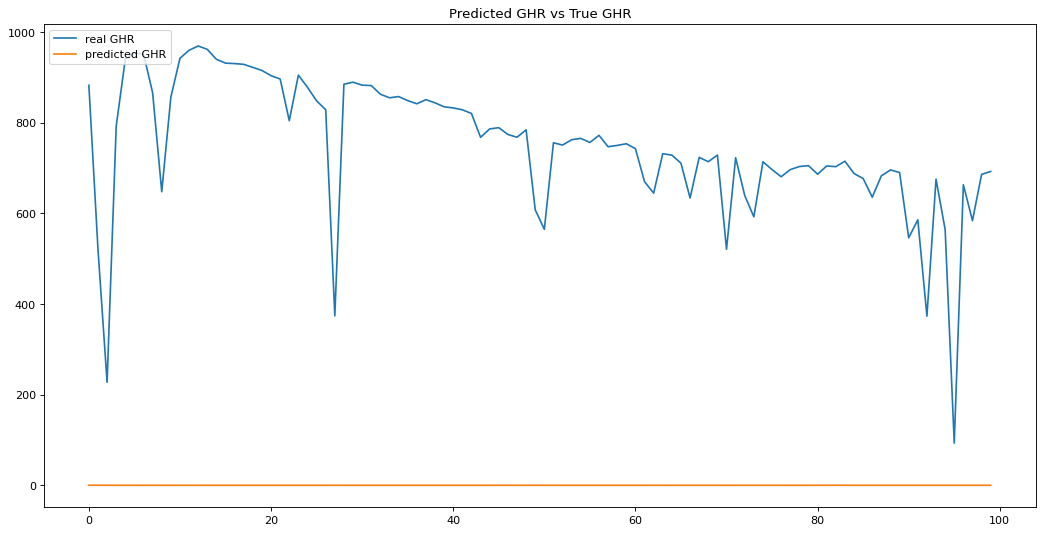

In [207]:
predictions=q_model.predict(inputs_test)

mse=tf.keras.metrics.MeanSquaredError()
mse.update_state(predictions.reshape(-1,), outputs_test.reshape(-1,))

mae= tf.keras.metrics.MeanAbsoluteError()
mae.update_state(predictions.reshape(-1,), outputs_test.reshape(-1,))

mape = tf.keras.metrics.MeanAbsolutePercentageError()
mape.update_state(predictions.reshape(-1,), outputs_test.reshape(-1,))


print('mae: '  +str(mae.result().numpy())) 
print('mse: '  +str(mse.result().numpy()))
print('mape: '  +str(mape.result().numpy())) 


figure(figsize=(16, 8), dpi=80)
plt.title('Predicted GHR vs True GHR')
plt.plot(outputs_test[:100], label='real GHR')
plt.plot(predictions[:100], label='predicted GHR')
plt.legend(loc="upper left")

plt.show()

### Appendix: Mask Mechanism

In [91]:
#MASK MECHANISM

inputs=np.random.rand(8,10,4)
inputs[0,2,:] = np.array([0.,0.,0.,0.])
inputs[3,2,:] = np.array([0.,0.,0.,0.])
inputs[6,2,:] = np.array([0.,0.,0.,0.])

hidden_dim=3
x_t = tf.constant(inputs[:,2,:])
print(' ')
print('INPUTS AT A GIVEN TIMESTEP (shape = (batch_size, n_features)): ')
print('0. values indicates missing values for the batch elements at that given timestep')
print(' ')
print(x_t)
mask =(x_t != 0.)
mask = tf.reduce_any(mask, axis=1)
mask = tf.transpose(tf.stack([mask]*hidden_dim),perm=[1,0])
print(' ')
print('MASK: ')
print(' ')
print(mask)
print(' ')

h_t = tf.random.uniform((8,hidden_dim))

#create a copy
h_t_copy = deepcopy(h_t)

#h goes trough computations
h_t *= 0.
h_t += 1.

#where mask is triggered restore old values of h
print('H STATE AFTER MASKING: ')
print('1. values represent batch elements for whose computations happened is kept')
print(' ')
print(tf.where(mask, h_t, h_t_copy))



 
INPUTS AT A GIVEN TIMESTEP (shape = (batch_size, n_features)): 
0. values indicates missing values for the batch elements at that given timestep
 
tf.Tensor(
[[0.         0.         0.         0.        ]
 [0.53974642 0.81396788 0.08329162 0.27181304]
 [0.06273725 0.12004463 0.74871741 0.08428133]
 [0.         0.         0.         0.        ]
 [0.52114619 0.54580802 0.0657859  0.1125229 ]
 [0.55510773 0.3509339  0.65636691 0.01301087]
 [0.         0.         0.         0.        ]
 [0.13160344 0.92831289 0.2793568  0.54265429]], shape=(8, 4), dtype=float64)
 
MASK: 
 
tf.Tensor(
[[False False False]
 [ True  True  True]
 [ True  True  True]
 [False False False]
 [ True  True  True]
 [ True  True  True]
 [False False False]
 [ True  True  True]], shape=(8, 3), dtype=bool)
 
H STATE AFTER MASKING: 
1. values represent batch elements for whose computations happened is kept
 
tf.Tensor(
[[0.61987936 0.6568868  0.68404746]
 [1.         1.         1.        ]
 [1.         1.         1.   